In [1]:
%%time
import os as os
os.chdir('C:\Users\Falco\Desktop\directory\WRMD_paper')
data_path = 'C:\Users\Falco\Desktop\directory\WRMD_paper\data'
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
%run Settings.py
from WRMDpy import Syndrome as Syndrome


plt.style.use('fivethirtyeight')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.family'] = "serif"

ERROR:root:File `u'Settings.py'` not found.
ERROR:root:File `u'Settings.py'` not found.


Wall time: 5.04 s


In [2]:
%%time
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#from sklearn.cross_validation import
from sklearn.model_selection import StratifiedKFold ,cross_val_score, train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import learning_curve
from pandas_ml import ConfusionMatrix
from textblob import TextBlob
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

Wall time: 0 ns


In [3]:
%%time
data = Syndrome.read_data(data_path+'\Training dataset_WMME_May 7 2018.csv')
data.shape

Wall time: 1.57 s


In [4]:
data.head()

,WRMD_ID,Case,Admitted_at,Species,Organization,Address_found,Latitude,Longitude,Disposition,Dispositioned_at,...,Reasons,Condition,Diagnosis,Notes,c1,c2,c3,c4,c5,condition_predict
Admitted_at,,,,,,,,,,,,,,,,,,,,,
2017-10-10,797939,17-4838,2017-10-10,Rock Pigeon,Wildlife Care Association of Sacramento,1485 Eureka Rd Roseville CA,38.752975,-121.251392,Pending,NaN,...,"Appears sick or injured, was flapping around o...",cns Walking in circles comments Finder explai...,Poisoned,NaN,neurologic disease,None,None,None,None,neurologic disease
2017-10-09,797531,17-3709,2017-10-09,Rock Pigeon,California Wildlife Center,Corner of Figueroa and Gage @ Gas Station Los ...,33.982069,-118.282970,Euthanized +24hr,10/10/2017,...,FOG; can't fly; head twitch,cns Head shake FOG cant fly head twitch empty,empty,NaN,neurologic disease,None,None,None,None,neurologic disease
2017-10-07,785529,17-2956,2017-10-07,Rock Pigeon,WildCare,2420 Van Ness San Francisco CA,37.797919,-122.423591,Euthanized in 24hr,10/7/2017,...,Unable to fly,comments neuro no signs of trauma looks like s...,suspect sarco,NaN,neurologic disease,None,None,None,None,neurologic disease
2017-10-07,719028,17-2955,2017-10-07,Rock Pigeon,WildCare,425 Buchanan San Francisco CA,37.774006,-122.427646,Euthanized in 24hr,10/7/2017,...,Neuro,comments neuro no signs of trauma looks like s...,suspect sarco,NaN,neurologic disease,None,None,None,None,neurologic disease
2017-10-10,797863,17-2977,2017-10-10,Northern Band-tailed Pigeon or Band-tailed Pigeon,Santa Barbara Wildlife Care Network,895 Buena Vista Rd. Montecito CA,34.447379,-119.611831,Euthanized +24hr,10/12/2017,...,found on ground,cns head tick and slight torticollis may be si...,empty,NaN,neurologic disease,None,None,None,None,neurologic disease


In [5]:
len(data.condition_predict.unique())

12

In [6]:
data.condition_predict.iloc[0]

'neurologic disease'

In [7]:
data.Condition.iloc[0]

'cns Walking in circles  comments Finder explained condition bird was in when found and it sounded like the bird was poisoned   Appears sick or injured was flapping around on the ground Started hyperventilating Vomitted did not attempt to get away  Poisoned'

In [8]:
%%time
h_data = Syndrome.read_data_historic(data_path+'\historic_data_2013-01-01_2018-05-22_above_all major centers.csv')
h_data.shape

Wall time: 1min 15s


In [9]:
h_data.Admitted_at.max()

'2018-05-22'

In [10]:
h_data.Admitted_at.min()

'2013-01-02'

In [11]:
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words


def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]


def bag_of_words(data_frame, historical_data):
    X_train, X_test, y_train, y_test = train_test_split(data_frame['Condition'], data_frame['condition_predict'], test_size=0.2, random_state=0)
    
    count_vect = CountVectorizer(analyzer=split_into_lemmas,ngram_range= (1, 3), encoding='utf8',stop_words =None)
    X_train_counts = count_vect.fit_transform(X_train)
    
    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    
    print('Training shape')
    print (X_train_tfidf.shape)
    
    X_new_counts = count_vect.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_new_counts)

    print ('Testing shape')
    print (X_test_tfidf.shape)
    
    
    print ('Historical data')
    X_hist_counts = count_vect.transform(historical_data['ConditionO'])
    X_hist_tfidf = tfidf_transformer.transform(X_hist_counts)
    print (X_hist_tfidf.shape)

    
    return X_train_tfidf, y_train, X_test_tfidf, y_test, X_hist_tfidf, count_vect

In [12]:
%%time
X_train_tfidf, y_train, X_test_tfidf, y_test, X_hist_tfidf, count_vectrotize_obj = bag_of_words(data_frame= data, historical_data= h_data)

Training shape
(2464, 4663)
Testing shape
(617, 4663)
Historical data
(219767, 4663)
Wall time: 2min 40s


In [13]:
X_train_tfidf

<2464x4663 sparse matrix of type '<type 'numpy.float64'>'
	with 55170 stored elements in Compressed Sparse Row format>

In [14]:
%%time
features = count_vectrotize_obj.get_feature_names()

Wall time: 5 ms


# Tuning hyper-parameters for precision
()
Fitting 5 folds for each of 85 candidates, totalling 425 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed: 30.6min finished
C:\Users\Falco\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
()
{'kernel': 'poly', 'C': 0.25, 'gamma': 4, 'degree': 3, 'probability': True}
()
Grid scores on development set:
()
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 0.001}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 0.0001}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 0.001}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 1e-05}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 0.001}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 0.0001}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 0.001}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 1e-05}
0.795 (+/-0.079) for {'kernel': 'rbf', 'C': 100, 'probability': True, 'gamma': 0.001}
0.029 (+/-0.000) for {'kernel': 'rbf', 'C': 100, 'probability': True, 'ga

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 425 out of 425 | elapsed: 32.3min finished
C:\Users\Falco\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
()
{'kernel': 'rbf', 'C': 1000, 'probability': True, 'gamma': 0.001}
()
Grid scores on development set:
()
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 0.001}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 0.0001}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 0.001}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'probability': True, 'gamma': 1e-05}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 0.001}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 0.0001}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 0.001}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 10, 'probability': True, 'gamma': 1e-05}
0.488 (+/-0.048) for {'kernel': 'rbf', 'C': 100, 'probability': True, 'gamma': 0.001}
0.083 (+/-0.000) for {'kernel': 'rbf', 'C': 100, 'probability': True, 'gamma': 0.00

Accuracy of model on cross validation dataset while training
Accuracy: 0.799569 (+/- 0.027052)
Confusion matrix showing classification on cross validation dataset while training


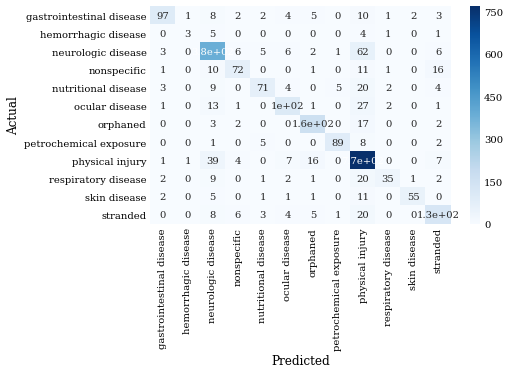

Best paraamters for the algorithm

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
('Accuracy of SVC on holdout data: ', 0.826580226904376)


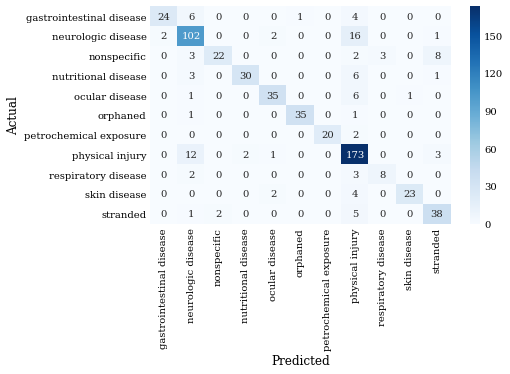

Adjusting the predictions
by comparing class wise prediction probabilities and predicted classes

('Accuracy of SVC on holdout data: ', 0.8282009724473258)
()


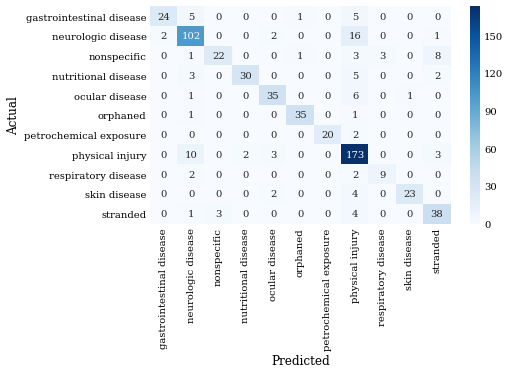

Wall time: 1h 4min 27s


In [15]:
%%time

## Set the parameters by cross-validation
#tuned_parameters = [{'n_estimators': [10, 100],
#           'max_features': ['auto', 'sqrt', 'log2'],
#           'max_depth' : [3, 6],
#           'criterion' :['gini', 'entropy']}]

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 
                     'gamma': [1e-3, 1e-4, 1e-3, 1e-5],
                     'C': [1, 10, 100, 100, 1000], 
                    'probability':[True]},
                   
                    {'kernel': ['linear'], 'C': [0.25,1, 10, 100, 1000], 'probability':[True]}, 
                    {'kernel': ['poly'], 'C': [0.25, 1, 10, 100, 1000], 'probability':[True], 
                     'degree':[1,3,5], 'gamma':[1,2, 4,8]}
                   ]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score, verbose = 1,  n_jobs= -1)
    clf.fit(X_train_tfidf, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
       
    y_true, y_pred = y_test, clf.predict(X_test_tfidf)
    print("Accuracy of SVC on holdout data: ",accuracy_score(y_true,y_pred))
    print()
    
    print(classification_report(y_test, y_pred))
    print()

print('Running the model with best parameters')

scores = cross_val_score(clf.best_estimator_, X_train_tfidf, y_train, cv = 5)

print('Accuracy of model on cross validation dataset while training')
print("Accuracy: %0.6f (+/- %0.6f)" % (scores.mean(), scores.std() * 2))
y_pred = cross_val_predict(clf.best_estimator_, X_train_tfidf, y_train, cv = 5)
df = pd.DataFrame({'prediction':y_pred, 'obsevred': y_train})
confusion_matrix = ConfusionMatrix(df.obsevred, df.prediction)
#print("Confusion matrix:\n%s" % confusion_matrix)
#confusion_matrix.print_stats()
print('Confusion matrix showing classification on cross validation dataset while training')
confusion_matrix.plot(normalized=False, backend='seaborn', cmap='Blues',annot= True)
plt.show()

print('Best paraamters for the algorithm\n')
print (clf.best_estimator_)
best_svc = clf.best_estimator_
y_true, y_pred = y_test, clf.predict(X_test_tfidf)

print("Accuracy of SVC on holdout data: ",accuracy_score(y_true,y_pred))

df = pd.DataFrame({'prediction':y_pred, 'obsevred': y_test})
confusion_matrix = ConfusionMatrix(df.obsevred, df.prediction)
#print("Confusion matrix:\n%s" % confusion_matrix)
#confusion_matrix.print_stats()
confusion_matrix.plot(normalized=False, backend='seaborn', cmap='Blues',annot= True, fmt='.0f')
plt.savefig(data_path+'/Best_model.png', dpi = 600)
plt.show()

probs = pd.DataFrame(clf.predict_proba(X_test_tfidf), columns=clf.classes_)
arr = np.argsort(-probs.values, axis=1)
df1 = pd.DataFrame(probs.columns[arr], index=probs.index)
df1.columns = ['rank_'+ str(col)  for col in df1.columns]
final_svc = pd.concat([df.reset_index(0), probs], axis=1)
final_svc = pd.concat([df.reset_index(0), probs, df1], axis=1)
def correct_classification(c):
    if c.obsevred ==  c.prediction:
        return 1
    else:
        return 0
final_svc['correct_prediction'] = final_svc.apply(correct_classification, axis=1)

def matching_two_methods(c):
    if c.prediction ==  c['rank_0']:
        return 1
    else:
        return 0

final_svc['method_match'] = final_svc.apply(matching_two_methods, axis=1)


def matching_rank_2(c):
    if c.method_match ==  0:
        if c.obsevred ==  c['rank_1']:
            return 1
        else:
            return 0 
    else:
        return 0

final_svc['match_rank_2'] = final_svc.apply(matching_rank_2, axis=1)

def adjust_prediction(c):
    if c.method_match ==  0:
        return c['rank_1']
    else:
        return c['prediction']

final_svc['prediction_adjusted'] = final_svc.apply(adjust_prediction, axis=1)


final_svc.to_csv('C:/Users/Falco/Desktop/directory/WRMD_paper/outputs/final_figures/final_svc.csv')

print ('Adjusting the predictions\nby comparing class wise prediction probabilities and predicted classes\n')

print("Accuracy of SVC on holdout data: ",accuracy_score(final_svc['obsevred'],final_svc['prediction_adjusted']))
print()
df = final_svc[['obsevred','prediction_adjusted']]
confusion_matrix = ConfusionMatrix(df.obsevred, df.prediction_adjusted)
#print("Confusion matrix:\n%s" % confusion_matrix)
#confusion_matrix.print_stats()
confusion_matrix.plot(normalized=False, backend='seaborn', cmap='Blues',annot= True, fmt='.0f')
plt.savefig('C:/Users/Falco/Desktop/directory/WRMD_paper/outputs/final_figures/Final_model.png', dpi = 600)
cm = confusion_matrix.to_dataframe()
cm.to_csv('C:/Users/Falco/Desktop/directory/WRMD_paper/outputs/final_figures/confusion_matrix.csv')
plt.show()


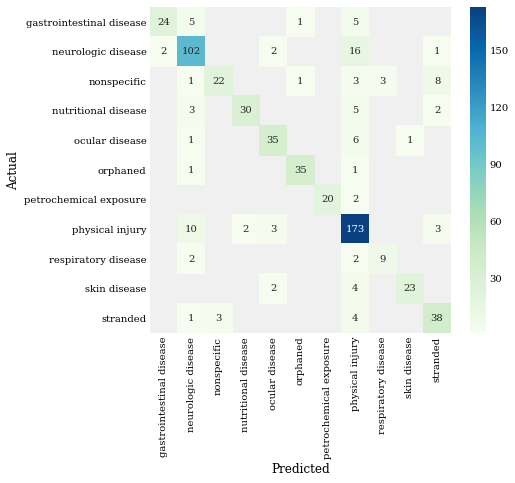

In [16]:
import seaborn as sns
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize =(6,6))
cm.replace(0, np.nan, inplace= True)
sns.heatmap(cm, cmap='GnBu', mask=cm.isnull(),annot=True, fmt='.0f')
plt.show()

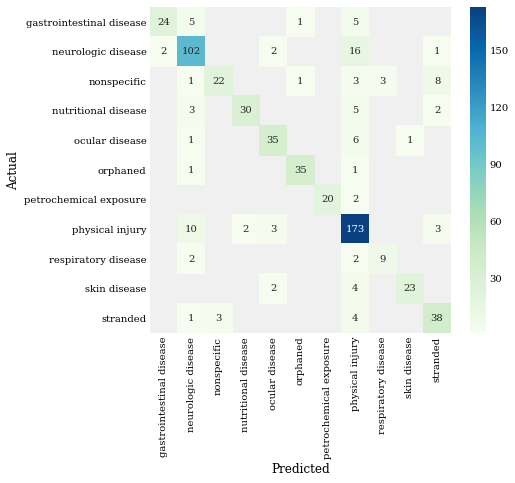

In [17]:
import seaborn as sns
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize =(6,6))
cm.replace(0, np.nan, inplace= True)
sns.heatmap(cm, cmap='GnBu', annot=True, fmt='.0f')
plt.show()

In [18]:
confusion_matrix.to_dataframe().fillna(0)

Predicted,gastrointestinal disease,neurologic disease,nonspecific,nutritional disease,ocular disease,orphaned,petrochemical exposure,physical injury,respiratory disease,skin disease,stranded
Actual,,,,,,,,,,,
gastrointestinal disease,24.0,5.0,0.0,0.0,0.0,1.0,0.0,5,0.0,0.0,0.0
neurologic disease,2.0,102.0,0.0,0.0,2.0,0.0,0.0,16,0.0,0.0,1.0
nonspecific,0.0,1.0,22.0,0.0,0.0,1.0,0.0,3,3.0,0.0,8.0
nutritional disease,0.0,3.0,0.0,30.0,0.0,0.0,0.0,5,0.0,0.0,2.0
ocular disease,0.0,1.0,0.0,0.0,35.0,0.0,0.0,6,0.0,1.0,0.0
orphaned,0.0,1.0,0.0,0.0,0.0,35.0,0.0,1,0.0,0.0,0.0
petrochemical exposure,0.0,0.0,0.0,0.0,0.0,0.0,20.0,2,0.0,0.0,0.0
physical injury,0.0,10.0,0.0,2.0,3.0,0.0,0.0,173,0.0,0.0,3.0
respiratory disease,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2,9.0,0.0,0.0


In [19]:
confusion_matrix.to_dataframe().fillna(0).sum(axis = 1)

Actual
gastrointestinal disease     35.0
neurologic disease          123.0
nonspecific                  38.0
nutritional disease          40.0
ocular disease               43.0
orphaned                     37.0
petrochemical exposure       22.0
physical injury             191.0
respiratory disease          13.0
skin disease                 29.0
stranded                     46.0
dtype: float64

Predicted,gastrointestinal disease,neurologic disease,nonspecific,nutritional disease,ocular disease,orphaned,petrochemical exposure,physical injury,respiratory disease,skin disease,stranded
Actual,,,,,,,,,,,
gastrointestinal disease,0.685714,0.142857,0.000000,0.000000,0.000000,0.028571,0.000000,0.142857,0.000000,0.000000,0.000000
neurologic disease,0.016260,0.829268,0.000000,0.000000,0.016260,0.000000,0.000000,0.130081,0.000000,0.000000,0.008130
nonspecific,0.000000,0.026316,0.578947,0.000000,0.000000,0.026316,0.000000,0.078947,0.078947,0.000000,0.210526
nutritional disease,0.000000,0.075000,0.000000,0.750000,0.000000,0.000000,0.000000,0.150000,0.000000,0.000000,0.025000
ocular disease,0.000000,0.023256,0.000000,0.000000,0.813953,0.000000,0.000000,0.139535,0.000000,0.023256,0.000000
orphaned,0.000000,0.027027,0.000000,0.000000,0.000000,0.945946,0.000000,0.027027,0.000000,0.000000,0.000000
petrochemical exposure,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.909091,0.090909,0.000000,0.000000,0.000000
physical injury,0.000000,0.052356,0.000000,0.010471,0.005236,0.000000,0.000000,0.916230,0.000000,0.000000,0.015707
respiratory disease,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.153846,0.692308,0.000000,0.000000


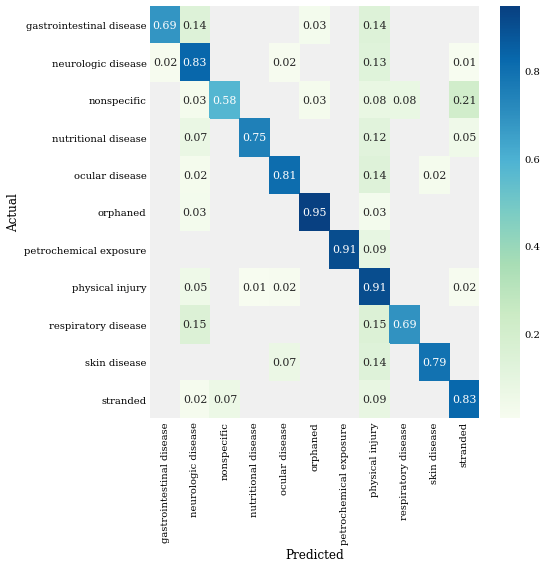

In [20]:
cm_perc = confusion_matrix.to_dataframe().fillna(0)
cm_perc = (cm_perc.fillna(0).T/cm_perc.fillna(0).sum(axis = 1)).T
cm_perc.replace(0, np.nan, inplace= True)
fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize =(8,8))
sns.heatmap(cm_perc, cmap='GnBu', annot=True, fmt='.2f', annot_kws={"size": 11})
plt.tight_layout()
plt.savefig('C:/Users/Falco/Desktop/directory/WRMD_paper/outputs/final_figures/Figure2_confusion_matrix.png', dpi = 600)
plt.savefig('C:/Users/Falco/Desktop/directory/WRMD_paper/outputs/final_figures/Figure2_confusion_matrix.svg', dpi = 600)

plt.show()

In [83]:
cm_perc.sum(axis=0)

Actual
gastrointestinal disease    0.779570
neurologic disease          1.038432
nonspecific                 1.034494
nutritional disease         0.827543
ocular disease              0.887980
orphaned                    0.959312
petrochemical exposure      0.919562
physical injury             1.136004
respiratory disease         0.719039
skin disease                0.860557
stranded                    0.934107
dtype: float64

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import seaborn as sns
lw = 2

In [ ]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [ ]:
lw = 4
def plot_ROC(start, end , ax, fpr, tpr, roc_auc):
    colors = ['#1b9e77', '#d95f02', '#7570b3','#e7298a']
    for i, color, s in zip(range(start, end), colors, clf.classes_[start:end]):
        name = 'ROC ' + clf.classes_[i]+'(area = {1:0.2f})'
        ax.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='{0} (AUC = {1:0.2f})'
                 ''.format(s, roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--', lw=lw)
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")

In [ ]:
n_classes = len(np.unique(y_train))
probs = clf.predict_proba(X_test_tfidf)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, probs[:, i], pos_label = clf.classes_[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), probs.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
cmap = sns.color_palette("Set2", 12)

plt.rcParams['figure.figsize'] = (6,6)
# Plot all ROC curves
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize =(18,6))
plot_ROC(start = 0, end = 4 , ax = ax1, fpr = fpr, tpr =tpr , roc_auc = roc_auc)
plot_ROC(start = 4, end = 8 , ax = ax2, fpr = fpr, tpr =tpr , roc_auc = roc_auc)
plot_ROC(start = 8, end = 12 , ax = ax3, fpr = fpr, tpr =tpr , roc_auc = roc_auc)
plt.savefig('C:\Users\Falco\Desktop\directory\WRMD_paper\outputs\ROC_curves.png', dpi = 600)
plt.show()

In [ ]:
clf

In [ ]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)


def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_mean_feats(X_train_tfidf, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = X_train_tfidf[grp_ids].toarray()
    else:
        D = X_train_tfidf.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [ ]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df['label'] = label
        dfs.append(feats_df)
    return dfs

In [ ]:
dataframes = top_feats_by_class(Xtr= X_test_tfidf, y= y_test, features=features)

In [ ]:
dataframes[0].head()

In [ ]:
clf.classes_

In [ ]:
for df in dataframes:
    df.set_index('feature').plot(kind = 'barh', title = df.label.unique()[0])

## Prediction on historical dataset

In [ ]:
%%time
predhist = clf.predict(X_hist_tfidf)
probs_hist = pd.DataFrame(clf.predict_proba(X_hist_tfidf), columns=clf.classes_, index= h_data.index)
arr = np.argsort(-probs_hist.values, axis=1)

In [ ]:
df2 = pd.DataFrame(probs_hist.columns[arr], index=h_data.index)
df2.columns = ['rank_'+ str(col)  for col in df2.columns]
df2.head()

In [ ]:
%% time
hist_final = h_data
hist_final['prediction'] =predhist 
hist_final = pd.concat([hist_final, probs_hist, df2], axis=1)
hist_final['method_match'] = hist_final.apply(matching_two_methods, axis=1)

def adjust_prediction(c):
    if c.method_match ==  0:
        return c['rank_0']
    else:
        return c['prediction']

final_svc['prediction_adjusted'] = final_svc.apply(adjust_prediction, axis=1)

hist_final['prediction_adjusted'] = hist_final.apply(adjust_prediction, axis=1)

In [ ]:
%% time
hist_final.to_csv(data_path+'/Predicted_final.csv')

## Final fit with all training data

In [ ]:
data.columns

In [ ]:
def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words


def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]


def bag_of_words_complete_model(data_frame):
    print('count vectorize')
    count_vect = CountVectorizer(analyzer=split_into_lemmas,ngram_range= (1, 3), encoding='utf8',stop_words =None)
    X_counts = count_vect.fit_transform(data_frame['Condition'])
    
    print('tfid tranformer')
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_counts)
    
    print('Training model on complete training dataset')
    print (X_tfidf.shape)
    
    return X_tfidf, data_frame['condition_predict'], count_vect, tfidf_transformer

best_svc = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
                  max_iter=-1, probability=True, random_state=None, shrinking=True,
                  tol=0.001, verbose=False)

In [ ]:
def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

from sklearn.pipeline import Pipeline

count_vect = CountVectorizer(analyzer=split_into_lemmas,ngram_range= (1, 3), encoding='utf8',stop_words =None)
tfidf_transformer = TfidfTransformer()
text_clf = Pipeline([('vect', count_vect), ('tdif', tfidf_transformer), ('clf', best_svc)])


In [ ]:
%%time
text_clf.fit(X=data['Condition'], y=data['condition_predict'])

In [ ]:
_ = joblib.dump(text_clf, 'classification_pipeline.pkl')

In [ ]:
%%time
X_tfidf, Y, count_vectrotize_obj_complete , tfidf_transformer_object= bag_of_words_complete_model(data_frame= data)

In [ ]:
%%time
best_svc = SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
                  max_iter=-1, probability=True, random_state=None, shrinking=True,
                  tol=0.001, verbose=False)
best_svc.fit(X=X_tfidf, y=Y)

In [ ]:
best_svc

## Dumping the model into a .pkl file for later use


In [30]:
from sklearn.externals import joblib
joblib.dump(best_svc, 'Syndrom_classification_model.pkl')

['Syndrom_classification_model.pkl']

In [31]:
joblib.dump(count_vectrotize_obj_complete, 'count_vectrotize_obj_complete.pkl')
joblib.dump(tfidf_transformer_object, 'tfidf_transformer_object.pkl')

['tfidf_transformer_object.pkl']